# Galactic plane fix for GNILC-based dust models

Adding small scales uniformly across the sky in logpoltens formalism adds artifacts to the galactic plane, in order to fix this problem we replace the inner part of the galaxy (inside the Planck 70% sky coverage mask) in the templates with the original emission, using the mask apodization to transition between the 2 regions.

In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

In [2]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [3]:
plt.style.use("seaborn-talk")

In [4]:
import pysm3 as pysm
import pysm3.units as u

In [5]:
nside = 2048
lmax = 2048

In [6]:
datadir = Path("data/")

## Load the Planck GAL070 Mask

In [7]:
planck_mask_filename = datadir / "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

if not planck_mask_filename.exists():
    !wget -O $planck_mask_filename "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

In [8]:
galplane_mask = hp.read_map(planck_mask_filename, ["GAL097"])

`dust_gnilc_logpoltens_varres_nomono.fits` is produced by the GNILC templates notebook:

* <https://pysm3.readthedocs.io/en/latest/preprocess-templates/gnilc_dust_logpoltens_templates.html>

In [9]:
log_pol_tens_varres = pysm.read_map(
    "dust_gnilc/raw/dust_gnilc_logpoltens_varres_nomono.fits",
    nside=2048,
    field=(0, 1, 2),
).value.astype(np.float64)

No physical unit associated with file /global/project/projectdirs/cmb/www/pysm-data/dust_gnilc/raw/dust_gnilc_logpoltens_varres_nomono.fits


In [10]:
(galplane_mask == 1).sum() / len(galplane_mask)

0.7580817937850952

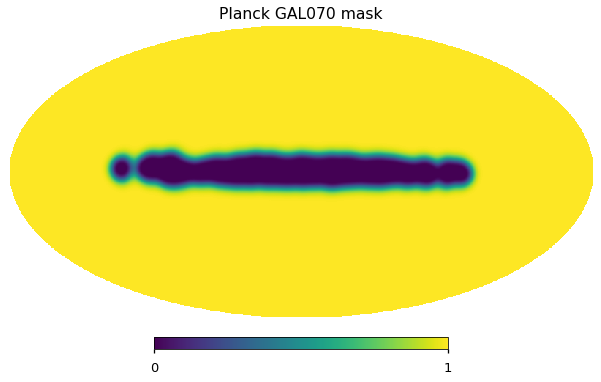

In [11]:
hp.mollview(galplane_mask, title="Planck GAL070 mask")

In [12]:
preproc_log_pol_tens_varres = log_pol_tens_varres.copy()
for comp in preproc_log_pol_tens_varres:
    comp[galplane_mask == 1] = 0

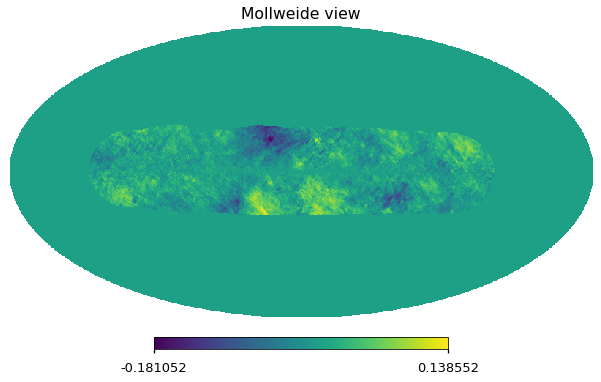

In [13]:
hp.mollview(preproc_log_pol_tens_varres[2])

In [14]:
galplane_mask = galplane_mask.astype(np.float64)

In [15]:
del log_pol_tens_varres

## Output

This file will be loaded by the `d11` model to apply the correction after generating small scales full sky.

In [16]:
hp.write_map(
    "production-data/raw/gnilc_dust_galplane.fits",
    list(preproc_log_pol_tens_varres) + [galplane_mask],
    fits_IDL=False,
    overwrite=True,
    coord="G",
    column_names=["TEMPERATURE", "Q_POLARISATION", "U_POLARISATION", "GALMASK"],
    dtype=np.float32,
)

## Apply correction to templates

In [17]:
from pysm3.utils import log_pol_tens_to_map, map_to_log_pol_tens

In [18]:
# for nside in [8192, 4096, 2048]:
for nside in [2048]:
    filename = f"production-data/gnilc_dust_template_nside{nside}.fits"
    m, h = hp.read_map(filename, field=(0, 1, 2), h=True, dtype=np.float64)
    m_logpoltens = map_to_log_pol_tens(m / 0.911)  # undo color correction
    m_logpoltens *= hp.ud_grade(galplane_mask, nside)
    m_logpoltens += hp.ud_grade(
        preproc_log_pol_tens_varres * (1 - galplane_mask), nside
    )
    m_galplane_fix = (
        log_pol_tens_to_map(m_logpoltens) * 0.911
    )  # apply color correction again
    hp.write_map(
        filename.replace("template", "template_galplanefix"),
        m_galplane_fix,
        extra_header=h,
        dtype=np.float32,
        overwrite=True,
    )

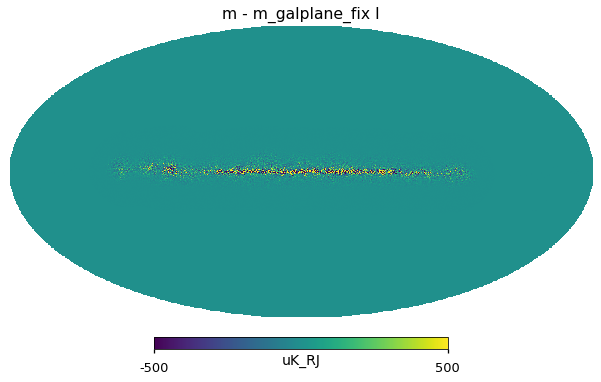

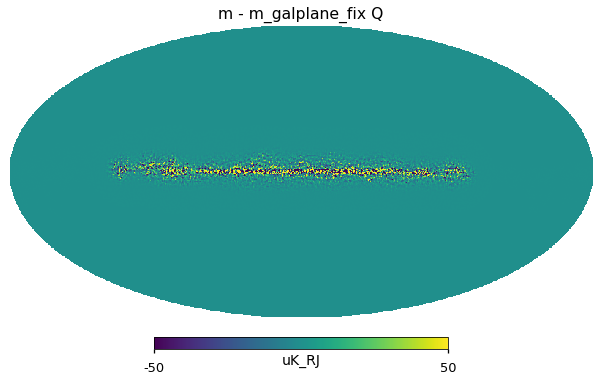

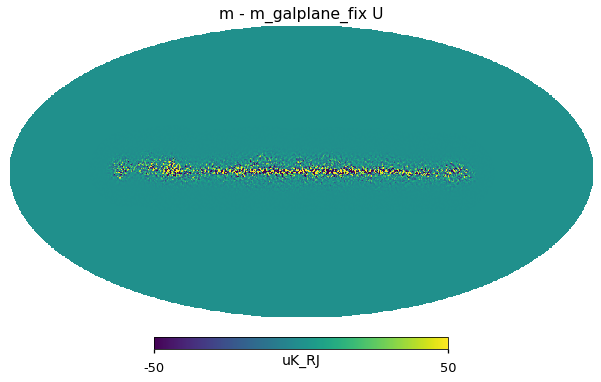

In [19]:
for i_pol, pol in enumerate("IQU"):
    vrange = 5e2 if pol == "I" else 5e1
    hp.mollview(
        m[i_pol] - m_galplane_fix[i_pol],
        min=-vrange,
        max=vrange,
        unit="uK_RJ",
        title=f"m - m_galplane_fix {pol}",
    )